In [1]:
from scipy.spatial.distance import squareform, pdist, cdist
from sklearn.metrics.pairwise import cosine_distances
from itertools import islice, combinations, product
from pyclustering.cluster.kmedoids import kmedoids
from collections import defaultdict
from sklearn.cluster import KMeans
from scipy.stats import hypergeom
from goatools import obo_parser
from scipy.linalg import eigh
from zipfile import ZipFile

import os
import time
import gzip
import graco
import shutil
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
# import Bio.UniProt.GOA as GOA
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
CPP_DIRECTORY = "/home/clusterduck123/Desktop/git/graco/graco/cpp"

In [3]:
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw_data"
PPI_DIRECTORY = f"{DATA_DIRECTORY}/PPI"
ANNOTATIONS_DIRECTORY = f"{DATA_DIRECTORY}/annotations"
MATRIX_DIRECTORY = f"{DATA_DIRECTORY}/matrix"
CLUSTERS_DIRECTORY = f"{DATA_DIRECTORY}/clusters"

if not os.path.exists(DATA_DIRECTORY):
    os.makedirs(DATA_DIRECTORY)
        
if not os.path.exists(RAW_DATA_DIRECTORY):
    os.makedirs(RAW_DATA_DIRECTORY)     
    
if not os.path.exists(PPI_DIRECTORY):
    os.makedirs(PPI_DIRECTORY)
    
if not os.path.exists(ANNOTATIONS_DIRECTORY):
    os.makedirs(ANNOTATIONS_DIRECTORY)
    
if not os.path.exists(MATRIX_DIRECTORY):
    os.makedirs(MATRIX_DIRECTORY)
    
if not os.path.exists(CLUSTERS_DIRECTORY):
    os.makedirs(CLUSTERS_DIRECTORY)

# TVD

In [4]:
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
GDV = graco.orbits(PPI_nx)
GCV = graco.coefficients(GDV)

In [28]:
df0 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd0.txt", delimiter=' ')
df1 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd1.txt", delimiter=' ')
df2 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd2.txt", delimiter=' ')
df3 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_tvd3.txt", delimiter=' ')

#df4 = pd.read_csv(f"{MATRIX_DIRECTORY}/sc_BioGRID_1tvd0.txt", delimiter=' ')
#
#sqD0 = squareform(df0)
#sqD1 = squareform(df1)
#sqD2 = squareform(df2)
#sqD3 = squareform(df3)

In [29]:
df0.index = df0.columns
df1.index = df1.columns
df2.index = df2.columns
df3.index = df3.columns

In [30]:
for (gene1, gene2) in combinations(df0.columns[df0.isna().all()], 2):
    df0[gene1][gene2] = 0
    df0[gene2][gene1] = 0
df0 = df0.fillna(1)
np.fill_diagonal(df0.values, 0)

for (gene1, gene2) in combinations(df1.columns[df1.isna().all()], 2):
    df1[gene1][gene2] = 0
    df1[gene2][gene1] = 0
df1 = df1.fillna(1)
np.fill_diagonal(df1.values, 0)

for (gene1, gene2) in combinations(df2.columns[df2.isna().all()], 2):
    df2[gene1][gene2] = 0
    df2[gene2][gene1] = 0
df2 = df2.fillna(1)
np.fill_diagonal(df2.values, 0)

for (gene1, gene2) in combinations(df3.columns[df3.isna().all()], 2):
    df3[gene1][gene2] = 0
    df3[gene2][gene1] = 0
df3 = df3.fillna(1)
np.fill_diagonal(df3.values, 0)

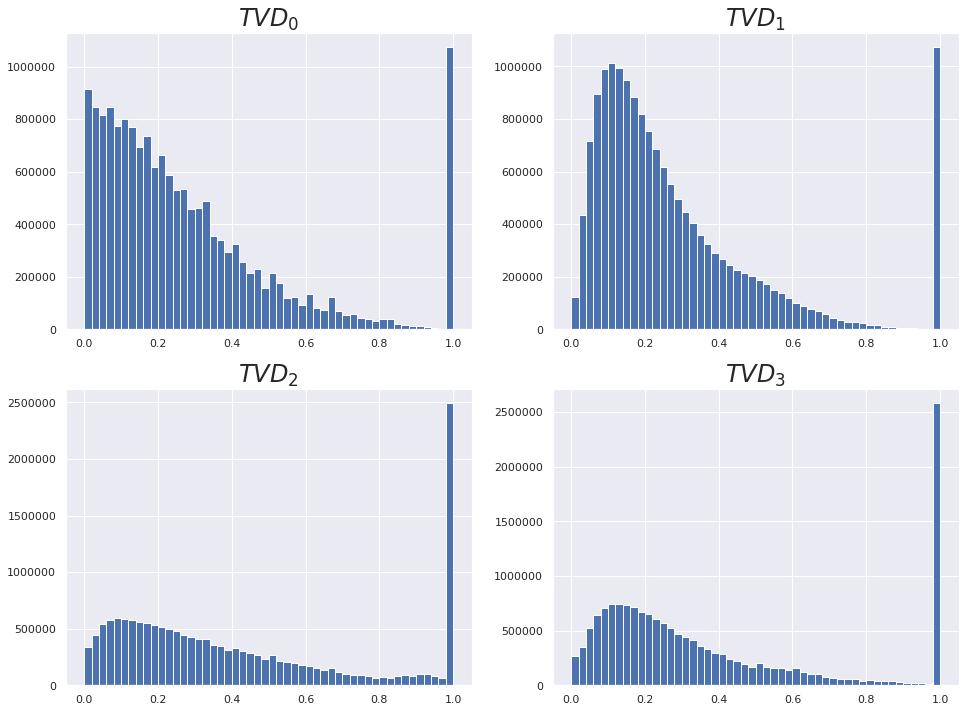

In [37]:
fig, axes = plt.subplots(2,2, figsize=(16,12))
fig.patch.set_alpha(0)

axes[0,0].set_title('$TVD_0$', fontsize=24)
axes[0,0].hist(squareform(df0), bins=50);
axes[0,1].set_title('$TVD_1$', fontsize=24)
axes[0,1].hist(squareform(df1), bins=50);
axes[1,0].set_title('$TVD_2$', fontsize=24)
axes[1,0].hist(squareform(df2), bins=50);
axes[1,1].set_title('$TVD_3$', fontsize=24)
axes[1,1].hist(squareform(df3), bins=50);

fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

# Ternary plots

In [4]:
_SQRT2 = np.sqrt(2) 

def hellinger(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [5]:
v1x, v1y = 0, 0
v2x, v2y = np.sqrt(2), 0
v3x, v3y = np.sqrt(2)/2, np.sqrt(3/2)

v1 = np.array([v1x, v1y])
v2 = np.array([v2x, v2y])
v3 = np.array([v3x, v3y])

T = np.array([v1, v2, v3])
Tinv = np.array([
    [np.sqrt(2)/2, -1/np.sqrt(6)],
    [0, np.sqrt(2/3)]
])

In [6]:
Tinv@(np.array([0.2, 0.3, 0.5])@T)

array([0.3, 0.5])

In [104]:
# Get orbit-specific graphlet coefficients
PPI_nx = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
PPI_GCV = graco.coefficients(PPI_nx)

N   = PPI_nx.number_of_nodes()
E   = PPI_nx.number_of_edges()
rho = nx.density(PPI_nx)
m   = int(N/2 - np.sqrt(N**2/4-E))
beta = 0.19772
r1 = 0.00285
r2 = 0.04325
r3 = 0.11563

In [112]:
PPI = nx.read_edgelist(f"{PPI_DIRECTORY}/BioGRID_sc.txt")
PPI_GCV = graco.coefficients(PPI)

ER = nx.erdos_renyi_graph(N, rho)
ER_GCV = graco.coefficients(ER)

BA = nx.barabasi_albert_graph(N, m)
BA_GCV = graco.coefficients(BA)

WS = nx.watts_strogatz_graph(N, int(2*E/N), beta)
WS_GCV = graco.coefficients(WS)

GEO1 = nx.random_geometric_graph(N, radius=r1, dim=1)
GEO1_GCV = graco.coefficients(GEO1)

GEO2 = nx.random_geometric_graph(N, radius=r2, dim=2)
GEO2_GCV = graco.coefficients(GEO2)

GEO3 = nx.random_geometric_graph(N, radius=r3, dim=3)
GEO3_GCV = graco.coefficients(GEO3)

sample_dict = {'PPI'    : PPI_GCV[0],
               'ER'     :  ER_GCV[0], 
               'BA'     :  BA_GCV[0],
               'WS'     :  WS_GCV[0], 
               '$GEO_1$':GEO1_GCV[0],
               '$GEO_2$':GEO2_GCV[0],
               '$GEO_3$':GEO3_GCV[0],
                   }
sample_list = list(sample_dict.keys())
sample_len  = len(sample_list)

colors = sns.color_palette(n_colors=sample_len)

In [116]:
df = pd.DataFrame({'PPI'    : PPI_GCV[0]['0']['3'].dropna(),
                   'ER'     :  ER_GCV[0]['0']['3'].dropna(), 
                   'BA'     :  BA_GCV[0]['0']['3'].dropna(), 
                   'WS'     :  WS_GCV[0]['0']['3'].dropna(), 
                   '$GEO_1$':GEO1_GCV[0]['0']['3'].dropna(),
                   '$GEO_2$':GEO2_GCV[0]['0']['3'].dropna(),
                   '$GEO_3$':GEO3_GCV[0]['0']['3'].dropna(),
                   })

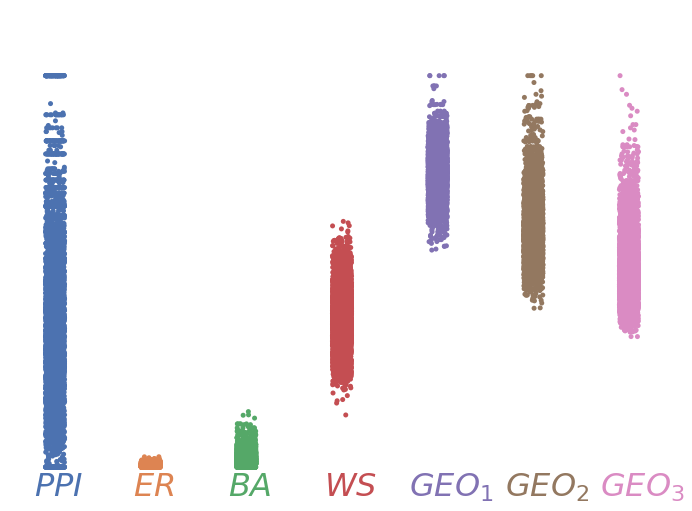

In [129]:
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_ylim([-buffer,1.1+buffer])
ax.set_xlim([-buffer,sample_len+10+buffer])
ax.axis('off')

ax.annotate(r'$PPI$' , (0-3*buffer  , -buffer), fontsize=32, color=colors[0])
ax.annotate(r'$ER$'  , (1-2.5*buffer, -buffer), fontsize=32, color=colors[1])
ax.annotate(r'$BA$'  , (2-2.5*buffer, -buffer), fontsize=32, color=colors[2])
ax.annotate(r'$WS$'  , (3-2.5*buffer, -buffer), fontsize=32, color=colors[3])
ax.annotate(r'$GEO_1$', (4-4*buffer  , -buffer), fontsize=32, color=colors[4])
ax.annotate(r'$GEO_2$', (5-4*buffer  , -buffer), fontsize=32, color=colors[5])
ax.annotate(r'$GEO_3$', (6-4*buffer  , -buffer), fontsize=32, color=colors[6])

sns.stripplot(data = df, ax=ax);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

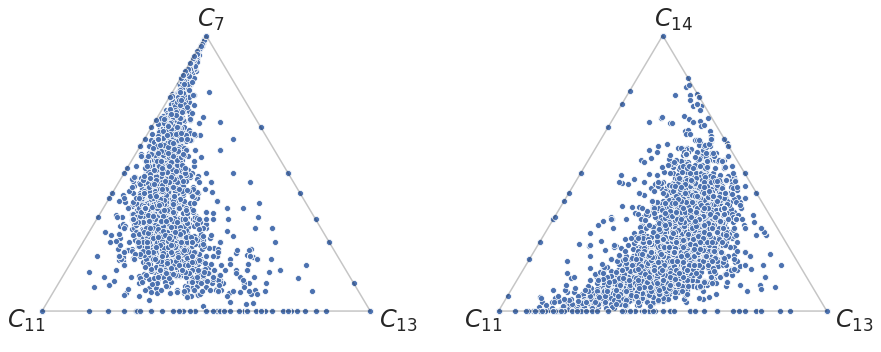

In [118]:
C2 = (PPI_GCV[0]['2'][['11', '13', '7' ]]@T).dropna()
C3 = (PPI_GCV[0]['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=sns.color_palette()[0]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=sns.color_palette()[0]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

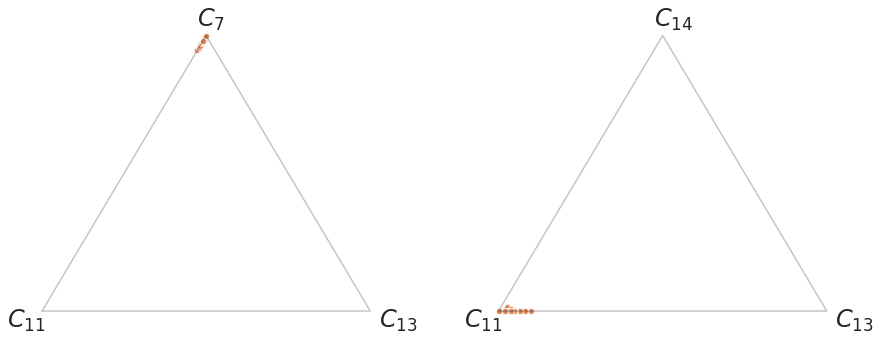

In [122]:
C2 = (ER_GCV[0]['2'][['11', '13', '7' ]]@T).dropna()
C3 = (ER_GCV[0]['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[1]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[1]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

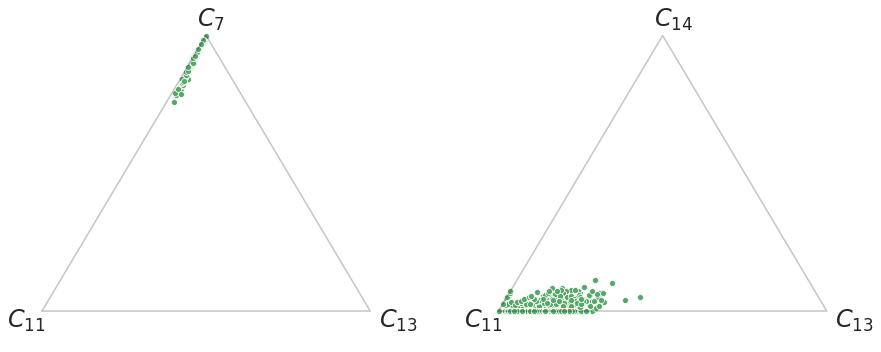

In [120]:
C2 = (BA_GCV[0]['2'][['11', '13', '7' ]]@T).dropna()
C3 = (BA_GCV[0]['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=sns.color_palette()[2]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=sns.color_palette()[2]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

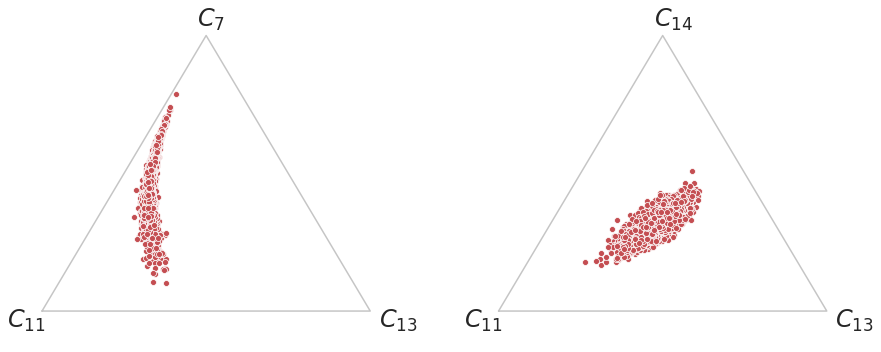

In [124]:
C2 = (WS_GCV[0]['2'][['11', '13', '7' ]]@T).dropna()
C3 = (WS_GCV[0]['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[3]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[3]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

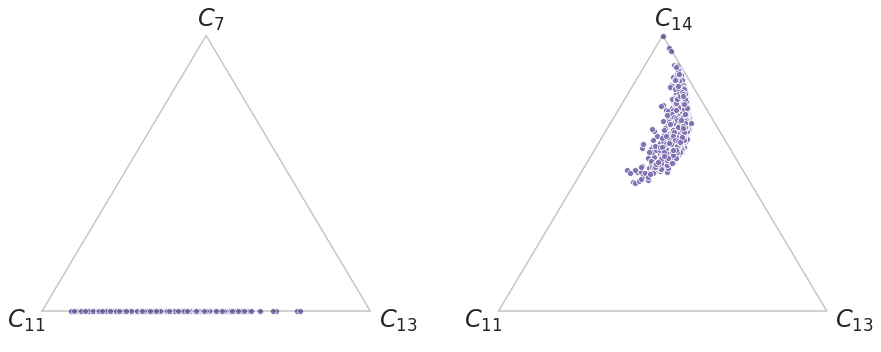

In [125]:
C2 = (GEO1_GCV[0]['2'][['11', '13', '7' ]]@T).dropna()
C3 = (GEO1_GCV[0]['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[4]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[4]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

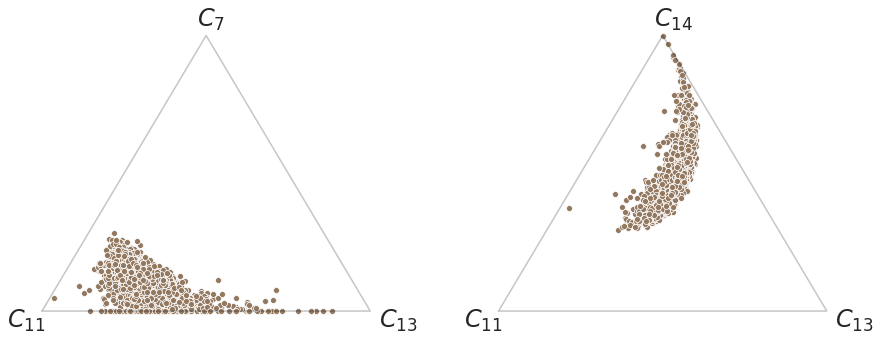

In [126]:
C2 = (GEO2_GCV[0]['2'][['11', '13', '7' ]]@T).dropna()
C3 = (GEO2_GCV[0]['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[5]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[5]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

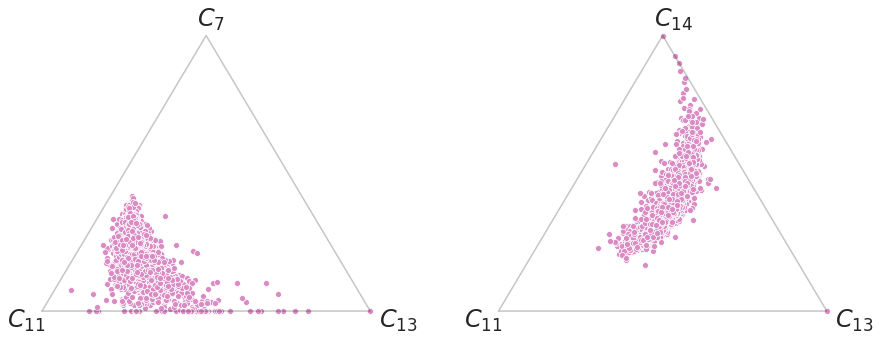

In [127]:
C2 = (GEO3_GCV[0]['2'][['11', '13', '7' ]]@T).dropna()
C3 = (GEO3_GCV[0]['3'][['11', '13', '14']]@T).dropna()

fig, axes = plt.subplots(1, 2, figsize=(15,6))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

buffer = 0.075

for ax in axes:
    ax.patch.set_alpha(0)
    ax.set_xlim([v1x-2*buffer,v2x+buffer])
    ax.set_ylim([v1y-2*buffer,v3y+buffer])
    ax.axis('off')

axes[0].annotate(r'$C_{11}$',(v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{13}$',(v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[0].annotate(r'$C_{7}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=axes[0], color=colors[6]);
axes[0].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);


axes[1].annotate(r'$C_{11}$', (v1x-2*buffer,v1y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
axes[1].annotate(r'$C_{14}$' ,(v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=axes[1], color=colors[6]);
axes[1].plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

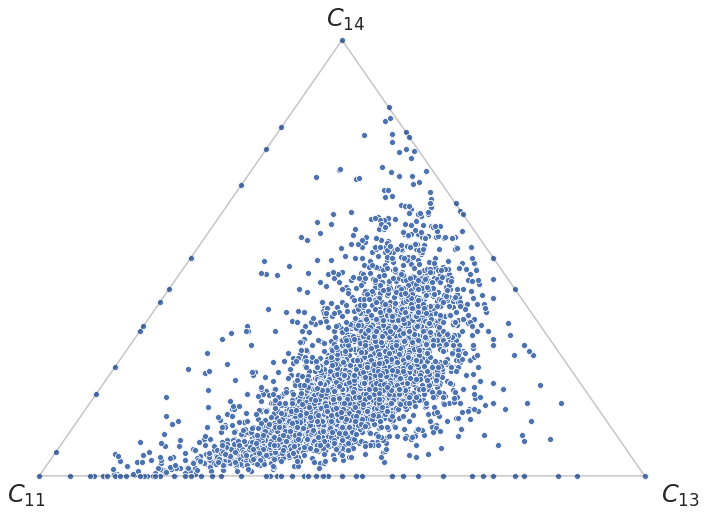

In [74]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax);
ax.plot([v1x,v2x,v3x,v1x], [v1y,v2y,v3y,v1y], 'k', alpha=0.25);

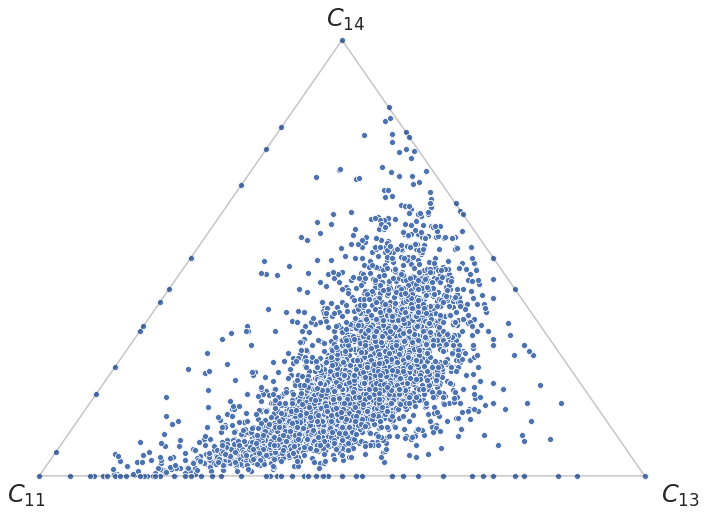

In [68]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C3, x=0, y=1, ax=ax);
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);

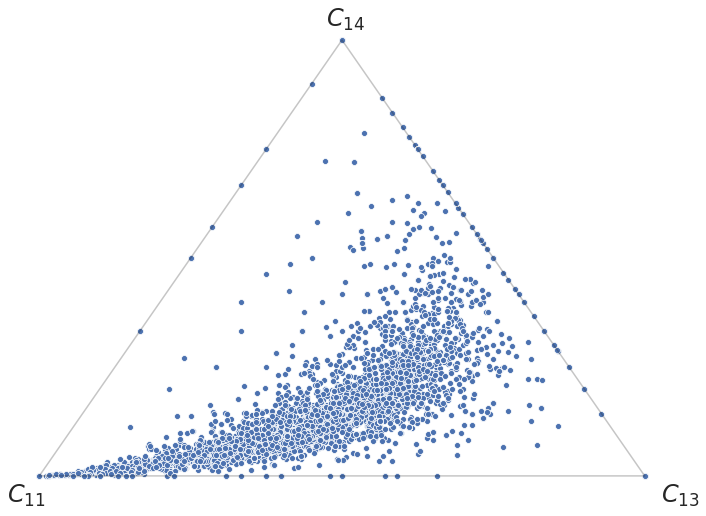

In [208]:
#Cluster coverage

C2 = (GCV['2']@T).dropna()

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = C2, x=0, y=1, ax=ax);
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);

In [135]:
(N-m)*m = E

561

In [61]:
x = np.random.uniform(size=[5,3])
x = x/np.sum(x)
graco.functions.tvd(x, [1/3,1/3,1/3])

1.9999999999999998

In [71]:
Pt = [0.2, 0.3, 0.5]
Pt = [1/3, 1/3, 1/3]
Pt_ = Pt@T
lb = 0.25
ub = lb+0.01
Pts = pd.DataFrame([x/sum(x) for x in np.random.uniform(size=[2**16,3]) 
                        if lb < hellinger(x/sum(x), Pt) < ub])@T

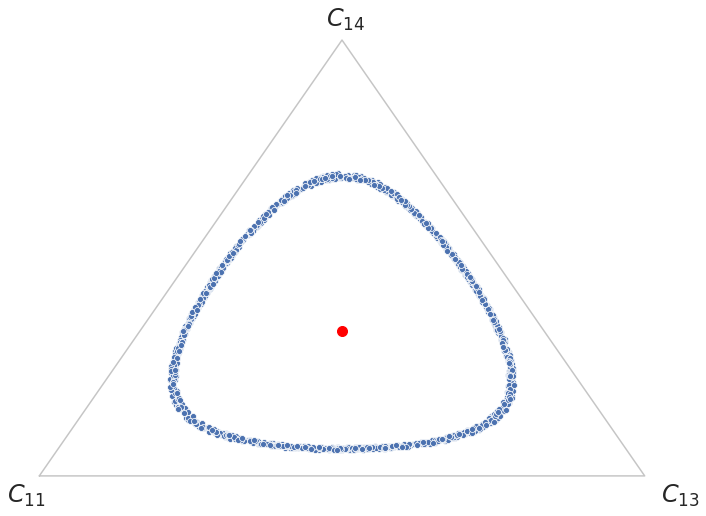

In [72]:
#Cluster coverage

fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)
ax.patch.set_alpha(0)

buffer = 0.075
ax.set_xlim([v1x-buffer,v2x+buffer])
ax.set_ylim([v1y-buffer,v3y+buffer])
ax.axis('off')

ax.annotate(r'$C_{11}$', (v1x-buffer  ,v1y-buffer  ), fontsize=24)
ax.annotate(r'$C_{13}$', (v2x+buffer/2,v2y-buffer  ), fontsize=24)
ax.annotate(r'$C_{14}$', (v3x-buffer/2,v3y+buffer/2), fontsize=24)

sns.scatterplot(data = Pts, x=0, y=1, ax=ax);
ax.plot(*(Pt@T), 'o', markersize=10, color='red')
ax.plot([0,np.sqrt(2)/2, np.sqrt(2), 0], [0,np.sqrt(3/2), 0, 0], 'k', alpha=0.25);
fig.savefig(f"{DATA_DIRECTORY}/plots/dummy.png")

In [163]:
Pt@T

array([0.70710678, 0.40824829])

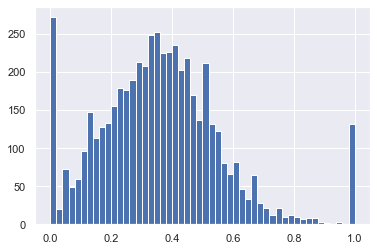

In [202]:
plt.hist(GCV['3']['11'].dropna(), bins=50);

In [206]:
sum(GCV['3']['14'] == 0)

470

In [ ]:
D = np.genfromtxt('/Users/markusyoussef/Desktop/git/supplements/data/matrix/sc_BioGRID_tvd0.txt')

In [ ]:
sqD = squareform(D)

In [ ]:
plt.hist(sqD, bins=50)

In [4]:
import numpy as np
from scipy.linalg import norm
from scipy.spatial.distance import euclidean

_SQRT2 = np.sqrt(2)     # sqrt(2) with default precision np.float64

def hellinger1(p, q):
    return norm(np.sqrt(p) - np.sqrt(q)) / _SQRT2


def hellinger2(p, q):
    return euclidean(np.sqrt(p), np.sqrt(q)) / _SQRT2


def hellinger3(p, q):
    return np.sqrt(np.sum((np.sqrt(p) - np.sqrt(q)) ** 2)) / _SQRT2

In [9]:
n = 10
x = np.random.uniform(size=n)
x = x/np.sum(x)

y = np.random.uniform(size=n)
y = y/np.sum(y)

In [16]:
%%timeit
h1 = hellinger1(x,y)

8.3 µs ± 110 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [17]:
%%timeit
h2 = hellinger2(x,y)

11.5 µs ± 114 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
%%timeit
h3 = hellinger3(x,y)

6.28 µs ± 49.8 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
